<a href="https://colab.research.google.com/github/LadyPary/CovidVaccineCorrelation/blob/main/Identifying_The_Social_And_Political_Correlates_of_COVID_19_Vaccination_Around_The_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center> Identifying The Social And Political Correlates of**
# **<center>  COVID-19 Vaccination Around The World**

##### <center>Zahra Rabbany Khorasgani
<center>parisa.rabbany.pr@gmail.com

[Google Colaboratory Notebook](https://colab.research.google.com/drive/13d3ihTFFrMwtNFHhj0lKWwWI8uBozG46?usp=sharing)

[GitHub Repository](https://github.com/LadyPary/CovidVaccineCorrelation)

##### <center>Department of Computer Science, Tehran University

##### <center>Scientific Computing

##### <center>Prof. Arta Jamshidi

##### <center>July. 18, 2021


# <center>**Abstract**

Here I present a data analysis on Covid-19 vaccination progress using machine learning and statistics. The primary goal is identifying and understanding the relations between the different political and social characteristics of a country and its vaccination rate to help decision-making in the future. 

I group the reasons for the uneven distribution of vaccination around the world into two categories of **political** and **social** reasons. The political reasons represent the government's inadequacy and the social reasons represent vaccine hesitancy. 

Using nationally representative data from the 204 countries around the world, I found a significant positive correlation between people vaccinated per hundred and freedom of the press status for a given country. 

Political features have a stronger correlation with people vaccinated per hundred than social features. 


People more likely to be vaccinated from countries that: 
1.  The press has the freedom
2.  Has Liberal democracy or Electoral autocracy.
3.  More people have tertiary education.
4.  More people agree with vaccine safety.

Although correlation is not causation, we can still gain an insightful understanding of this matter. Figuring out what's causing the relationship would require richer research.


# <center>**Introduction**

Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), the virus that causes COVID-19, reached pandemic status on March 11th, 2020. As of July 17th, 2021, the virus had spread to 213 countries and territories, infected over 190 million people, and resulted in over 4.08 million people deaths worldwide. The global solutions to slow the spread of the virus are social distancing and global vaccination. 

As COVID-19 is taking lives and damaging the economy, countries are trying to get the vaccination rate to above 70% as fast as possible. While some countries are close to achieving this goal, others are failing. 

Using data extracted from [Our World in Data](https://ourworldindata.org/) we examine the possible correlations between the following features and the people vaccinated per hundred in each country: 

**Political features:** Freedom of the press status, Political regimes, Main religion, Trust in politicians

**Social features:** Believe in vaccine safety, Higher education, Trust in doctors and nurses

The Methods used are:
1. **Visualization** using choropleth maps, histograms,  pie charts, and scatter plots, heat maps.
2. **Calculating the coefficient of correlation** using Spearman's Rank Correlation Coefficient and Pearson Correlation Coefficient.
3. **Feature importance method** using XGBoost regressor, Random Forest regressor, and Decision tree regressor in machine learning algorithms. 

# <center>**Code**

## **Data**

#### Import Python Packages

In [88]:
%load_ext google.colab.data_table
import pandas as pd
import numpy as np
import sklearn
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import Markdown, display


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


#### Load and Merge Data


In [89]:
# Links of data from github 
dataLinks = { "Vaccination Data" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/country_vaccinations.csv",
             "Freedom of the Press Status" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Freedom%20of%20the%20Press%20Status.csv",
             "Main Religion of the Country" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Main%20Religion%20of%20the%20Country.csv",
             "Political Regimes" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Political%20Regime.csv",
             "Tertiary Education for Aged 15+" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Tertiary%20Education%20Aged%2015%2B.csv",
             "Agree Vaccines Are Safe" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Share%20Agree%20Vaccines%20Are%20Safe.csv",
             "Trust in Doctors and Nurses" : "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Share%20Who%20Trust%20Doctors%20and%20Nurses.csv",
             "Trust in Politician": "https://raw.githubusercontent.com/LadyPary/CovidVaccineCorrelation/main/Trust%20in%20Politician.csv"
            }

def load_data(githubLink): 
  ''' function returns dataframe '''
  df = pd.read_csv(githubLink)
  return df

In [90]:
# Loading and preparing the vaccination data
vaccinationData = load_data(dataLinks["Vaccination Data"])

# Change the 'iso code' label to 'Code' for future merging 
vaccinationData = vaccinationData.rename(columns={'iso_code': 'Code'})

# Choose the "people_vaccinated_per_hundred" variable for correlations
selectedColumnsVaccine = vaccinationData[['Code', 'country','date','people_vaccinated_per_hundred']]
vaccinationData = selectedColumnsVaccine.copy()

In [91]:
#Number of Unique Countries
print(vaccinationData["Code"].value_counts())

NOR         225
LVA         223
OWID_ENG    218
OWID_SCT    218
OWID_WLS    213
           ... 
TCD          28
NIU          16
PCN           7
BES           1
TKM           1
Name: Code, Length: 218, dtype: int64


Number of countries = 204

In [92]:
# Handling the missing values for different days be replacing the nearest day
vaccinationData.interpolate(method='nearest', axis= 0, inplace=True, dtype='float64')

In [93]:
#@title Select a date to analyse the vaccination data around the world to this day.  
# Choosing a specific date for Vaccination Data, can be updated in the future
date = '2021-06-24' #@param {type:"date"}
vaccinationData = vaccinationData.loc[vaccinationData['date'] == date]

In [94]:
# Loading and preparing the features data
FreePress =load_data(dataLinks["Freedom of the Press Status"])
MainReligion =load_data(dataLinks["Main Religion of the Country"])
PoliticalRegimes =load_data(dataLinks["Political Regimes"])
TertiaryEducation =load_data(dataLinks["Tertiary Education for Aged 15+"])
VaccinesSafe =load_data(dataLinks["Agree Vaccines Are Safe"])
TrustDoctors =load_data(dataLinks["Trust in Doctors and Nurses"])
TrustPolitician =load_data(dataLinks["Trust in Politician"])

In [95]:
# Simplify column names
TertiaryEducation = TertiaryEducation.rename(columns={'Tertiary education for those aged 15+ (proportion), 1970-2050 (IIASA (2015))': 'Tertiary education 15+'})
VaccinesSafe = VaccinesSafe.rename(columns={'Share of people who agree vaccines are safe (Wellcome Trust, 2019)': 'People who agree vaccines are safe'})
TrustDoctors = TrustDoctors.rename(columns={'Share of people who trust doctors and nurses in their country': 'People who trust doctors and nurses in their country'})

In [96]:
vaccinationData = vaccinationData.merge(FreePress[['Code', 'Freedom of the Press Status']], how='outer', on='Code')

In [97]:
vaccinationData = vaccinationData.merge(MainReligion[['Code', 'Main religion ']], how='outer', on='Code')

In [98]:
vaccinationData = vaccinationData.merge(PoliticalRegimes[['Code', 'Political Regime']], how='outer', on='Code')

In [99]:
vaccinationData = vaccinationData.merge(TertiaryEducation[['Code', 'Tertiary education 15+']], how='outer', on='Code')

In [100]:
vaccinationData = vaccinationData.merge(VaccinesSafe[['Code', 'People who agree vaccines are safe']], how='outer', on='Code')

In [101]:
vaccinationData = vaccinationData.merge(TrustDoctors[['Code', 'People who trust doctors and nurses in their country']], how='outer', on='Code')

In [102]:
vaccinationData = vaccinationData.merge(TrustPolitician[['Code', 'TrustPolitician']], how='outer', on='Code')

In [103]:
vaccinationData.dropna(axis=0, how='any', subset=['Code', 'country'], inplace=True)

In [104]:
vaccinationData

,Code,country,date,people_vaccinated_per_hundred,Freedom of the Press Status,Main religion,Political Regime,Tertiary education 15+,People who agree vaccines are safe,People who trust doctors and nurses in their country,TrustPolitician
0,AFG,Afghanistan,2021-06-24,1.50,2500.0,Islam,1.0,NaN,94.237020,73.444790,NaN
1,ALB,Albania,2021-06-24,18.66,2500.0,Islam,3.0,NaN,63.838397,67.537413,2.790683
2,AND,Andorra,2021-06-24,50.04,3500.0,Christianity,NaN,NaN,NaN,NaN,NaN
3,AGO,Angola,2021-06-24,2.77,1500.0,Christianity,1.0,NaN,NaN,NaN,NaN
4,AIA,Anguilla,2021-06-24,61.75,NaN,Christianity,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
199,OWID_WLS,Wales,2021-06-24,71.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,WLF,Wallis and Futuna,2021-06-24,40.30,NaN,Christianity,NaN,NaN,NaN,NaN,NaN
201,YEM,Yemen,2021-06-24,0.90,1500.0,Islam,0.0,NaN,84.218867,66.586977,2.117509
202,ZMB,Zambia,2021-06-24,0.77,1500.0,Christianity,1.0,7.28078,80.544755,82.521060,3.046325


In [105]:
vaccinationData.shape

(204, 11)

In [106]:
# Saving the merged file as csv file
vaccinationData.to_csv('mergedVaccinationData.csv')

#### Explore data


In [107]:
def data_explore(df): 
  ''' returns information about the input dataframe '''
  
  display(Markdown("##**What does the dataframe look like? First few lines of dataframe:**"))
  print(df.head(), "\n") # what does the dataframe look like?
  display(Markdown('---'))

  display(Markdown("**Size of the Dataset:**"))
  print(df.shape, "\n") # what's size of the dataset? (how many instances we have)
  display(Markdown('---'))

  display(Markdown("**Dataframe Columns:**"))
  print(df.columns, "\n") # what are the columns (features) 
  display(Markdown('---'))

  display(Markdown("**Type of Each Column:**"))
  print(df.info(), "\n" )
  display(Markdown('---'))

  display(Markdown("##**Summary of Features :**"))
  display(Markdown("**Numerical Columns/Features :**"))
  print(df.describe(),"\n") # summary of each feature
  display(Markdown("**Categorical Columns/Feature:**"))
  print(df[["Main religion "]].describe(),"\n")
  display(Markdown('---'))

  display(Markdown("##**Unique Values of Each Categorical Column and Their Counts:**"))
  display(Markdown("**Unique Values of Main religion:**"))
  print(df["Main religion "].value_counts(),"\n")
  display(Markdown('---'))

  display(Markdown("**Number of Null Values in Dataframe:**"))
  print("Number of Null Values in Dataframe: " )
  print(df.isna().sum())

  return

In [108]:
data_explore(vaccinationData)

##**What does the dataframe look like? First few lines of dataframe:**

  Code  ... TrustPolitician
0  AFG  ...             NaN
1  ALB  ...        2.790683
2  AND  ...             NaN
3  AGO  ...             NaN
4  AIA  ...             NaN

[5 rows x 11 columns] 



---

**Size of the Dataset:**

(204, 11) 



---

**Dataframe Columns:**

Index(['Code', 'country', 'date', 'people_vaccinated_per_hundred',
       'Freedom of the Press Status', 'Main religion ', 'Political Regime',
       'Tertiary education 15+', 'People who agree vaccines are safe',
       'People who trust doctors and nurses in their country',
       'TrustPolitician'],
      dtype='object') 



---

**Type of Each Column:**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 11 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Code                                                  204 non-null    object 
 1   country                                               204 non-null    object 
 2   date                                                  204 non-null    object 
 3   people_vaccinated_per_hundred                         204 non-null    float64
 4   Freedom of the Press Status                           179 non-null    float64
 5   Main religion                                         198 non-null    object 
 6   Political Regime                                      163 non-null    float64
 7   Tertiary education 15+                                116 non-null    float64
 8   People who agree vaccines are safe                    134 no

---

##**Summary of Features :**

**Numerical Columns/Features :**

       people_vaccinated_per_hundred  ...  TrustPolitician
count                     204.000000  ...       133.000000
mean                       26.588578  ...         3.256026
std                        24.300552  ...         1.213344
min                         0.000000  ...         1.331338
25%                         3.882500  ...         2.363153
50%                        20.095000  ...         3.046325
75%                        48.937500  ...         4.000000
max                       116.380000  ...         6.397694

[8 rows x 7 columns] 



**Categorical Columns/Feature:**

       Main religion 
count             198
unique              7
top      Christianity
freq              133 



---

##**Unique Values of Each Categorical Column and Their Counts:**

**Unique Values of Main religion:**

Christianity              133
Islam                      44
Buddhism                    8
Unaffiliated Religions      6
Folk Religions              3
Hinduism                    3
Judaism                     1
Name: Main religion , dtype: int64 



---

**Number of Null Values in Dataframe:**

Number of Null Values in Dataframe: 
Code                                                     0
country                                                  0
date                                                     0
people_vaccinated_per_hundred                            0
Freedom of the Press Status                             25
Main religion                                            6
Political Regime                                        41
Tertiary education 15+                                  88
People who agree vaccines are safe                      70
People who trust doctors and nurses in their country    70
TrustPolitician                                         71
dtype: int64


### **Visualisation**



#### **Choropleth Maps**

**Share that agrees that vaccines are safe, 2018**:

The share of people who responded that they "strongly agree" or "somewhat agree" with the statement 'Vaccines are safe.'

**Projections of the share of the population aged 15+ educated to degree level by country, 2020**:

Projections are IIASA Global Education Trends (GET) estimates based on the continuation of current
trends.

**Share of people who trust doctors and nurses in their country, 2018:**
Survey respondents were asked: "How much do you trust doctors and nurses? Do you trust them a lot,some, not much, or not at all?" The "share of people who trust" is the sum of those who responded "a lot", and "some".

**World Map of the Freedom of the Press Status, 2017:**
The Freedom of the Press Status is measured by Freedom House. It measures the level of freedom and editorial independence enjoyed by the press.

**Political Regimes, 2018:**
Shown is each country's political regime classification in year 2018, where 0 = Closed autocracy; 1 = Electoral autocracy; 2 = Electoral democracy; and 3 = Liberaldemocracy.

**Main religion of the country , 2010:**
Religion with the largest share of followers in the country.

**Trust Politician:**
Peoples trust in politicians scaled from 0(no trust) to 7(most trust).

In [109]:
def plotGeographical(df, x, color, reverse, barTitle, plotTitle, tick=""):

  fig = go.Figure(data=go.Choropleth(
      locations = df['Code'],
      z = df[x],
      text = df['country'],
      colorscale = color, #'Greens'
      autocolorscale=False,
      reversescale= reverse,
      colorbar_tickprefix = tick,
      marker_line_color='darkgray',
      marker_line_width=0.5,
      colorbar_title = barTitle,
  ))
  fig.update_layout(
      title_text= plotTitle,
      geo=dict(
          showframe=False,
          showcoastlines=False,
          projection_type='natural earth'
      )
  )

  fig.show()

#numerical
plotGeographical(vaccinationData, 'people_vaccinated_per_hundred', 'Greens', False, 'Vaccinated per Hundred', 'Global People Vaccinated Per Hundred by {}'.format(date), "%")
plotGeographical(vaccinationData, 'Tertiary education 15+', 'purpor', False, 'Tertiary Education 15+ Proportion', 'Projections Of The Share Of The Population Aged 15+ Educated To Degree Level By Country, 2020', "%")
plotGeographical(vaccinationData, 'People who agree vaccines are safe', 'ylgnbu', False, 'People per Hundred', 'Global Share of People That Agrees Vaccines Are Safe, 2018', "%")
plotGeographical(vaccinationData, 'People who trust doctors and nurses in their country', 'haline', False, 'People per Hundred', 'Share Of People Who Trust Doctors And Nurses In Their Country, 2018:', "%")
plotGeographical(vaccinationData, 'TrustPolitician', 'blackbody', False, 'On scale of 0 to 7', 'Share Of People Who Trust Politician In Their Country, 2016:')



In [110]:
#categorical

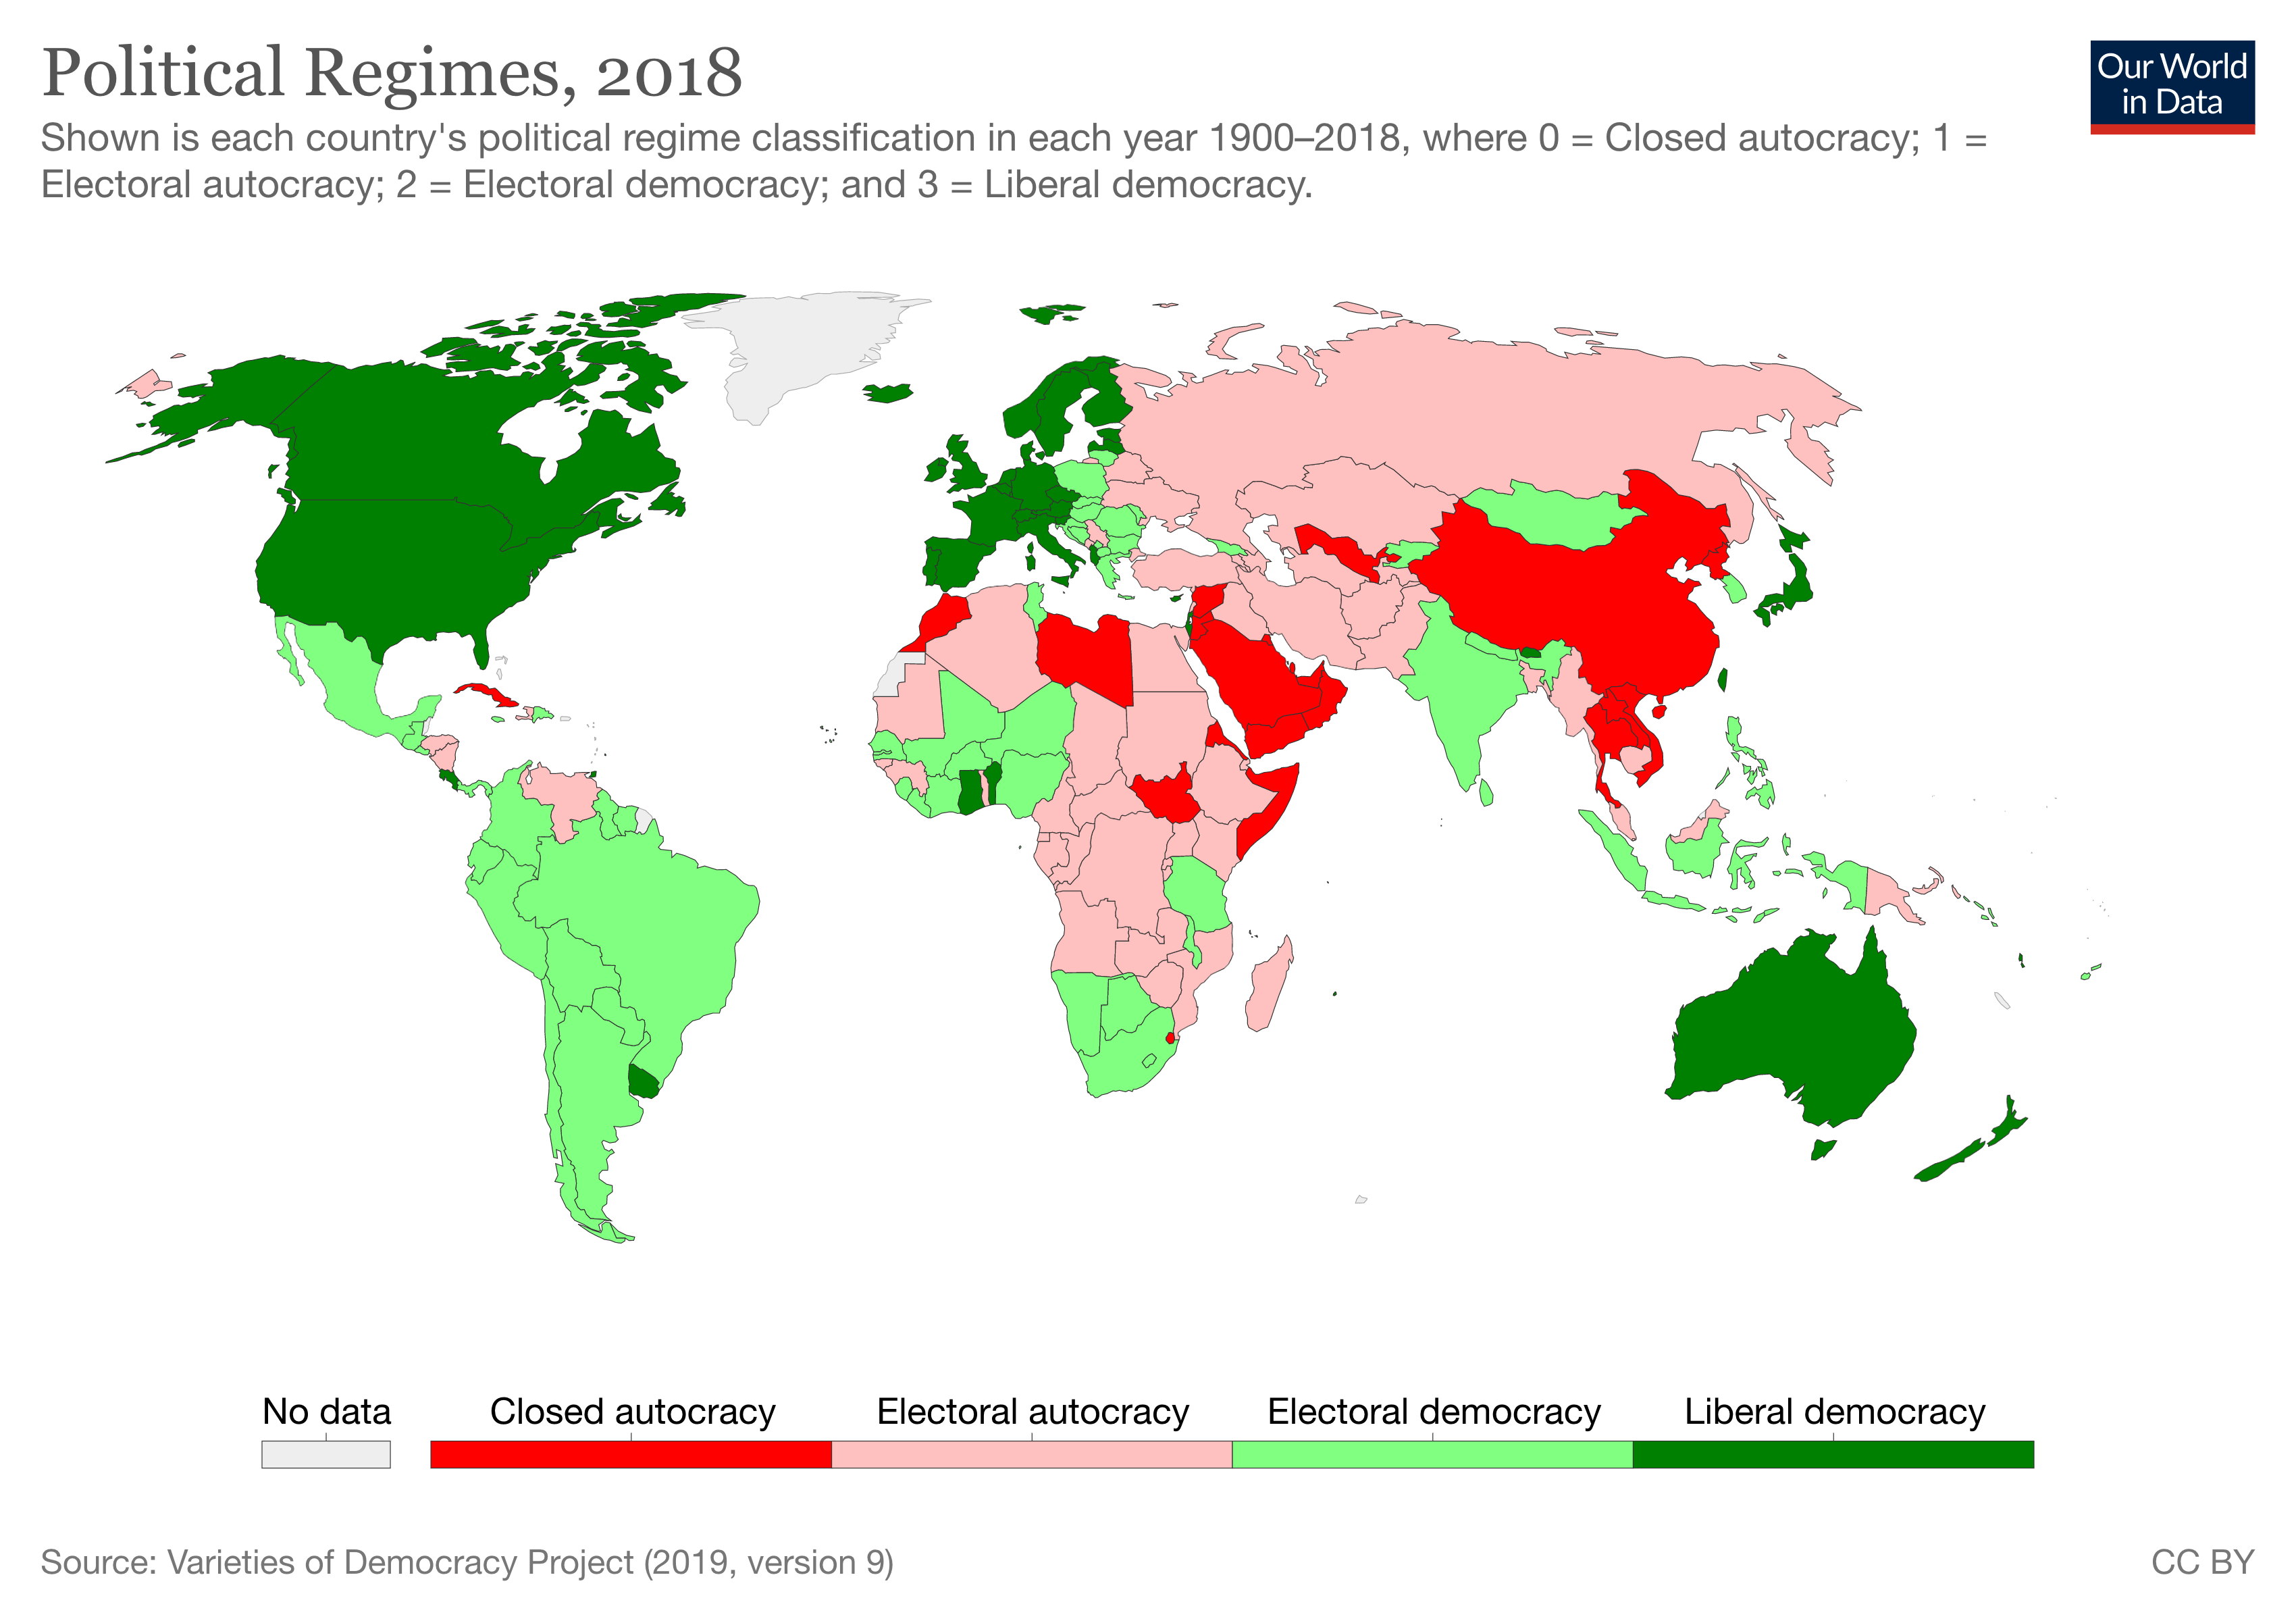

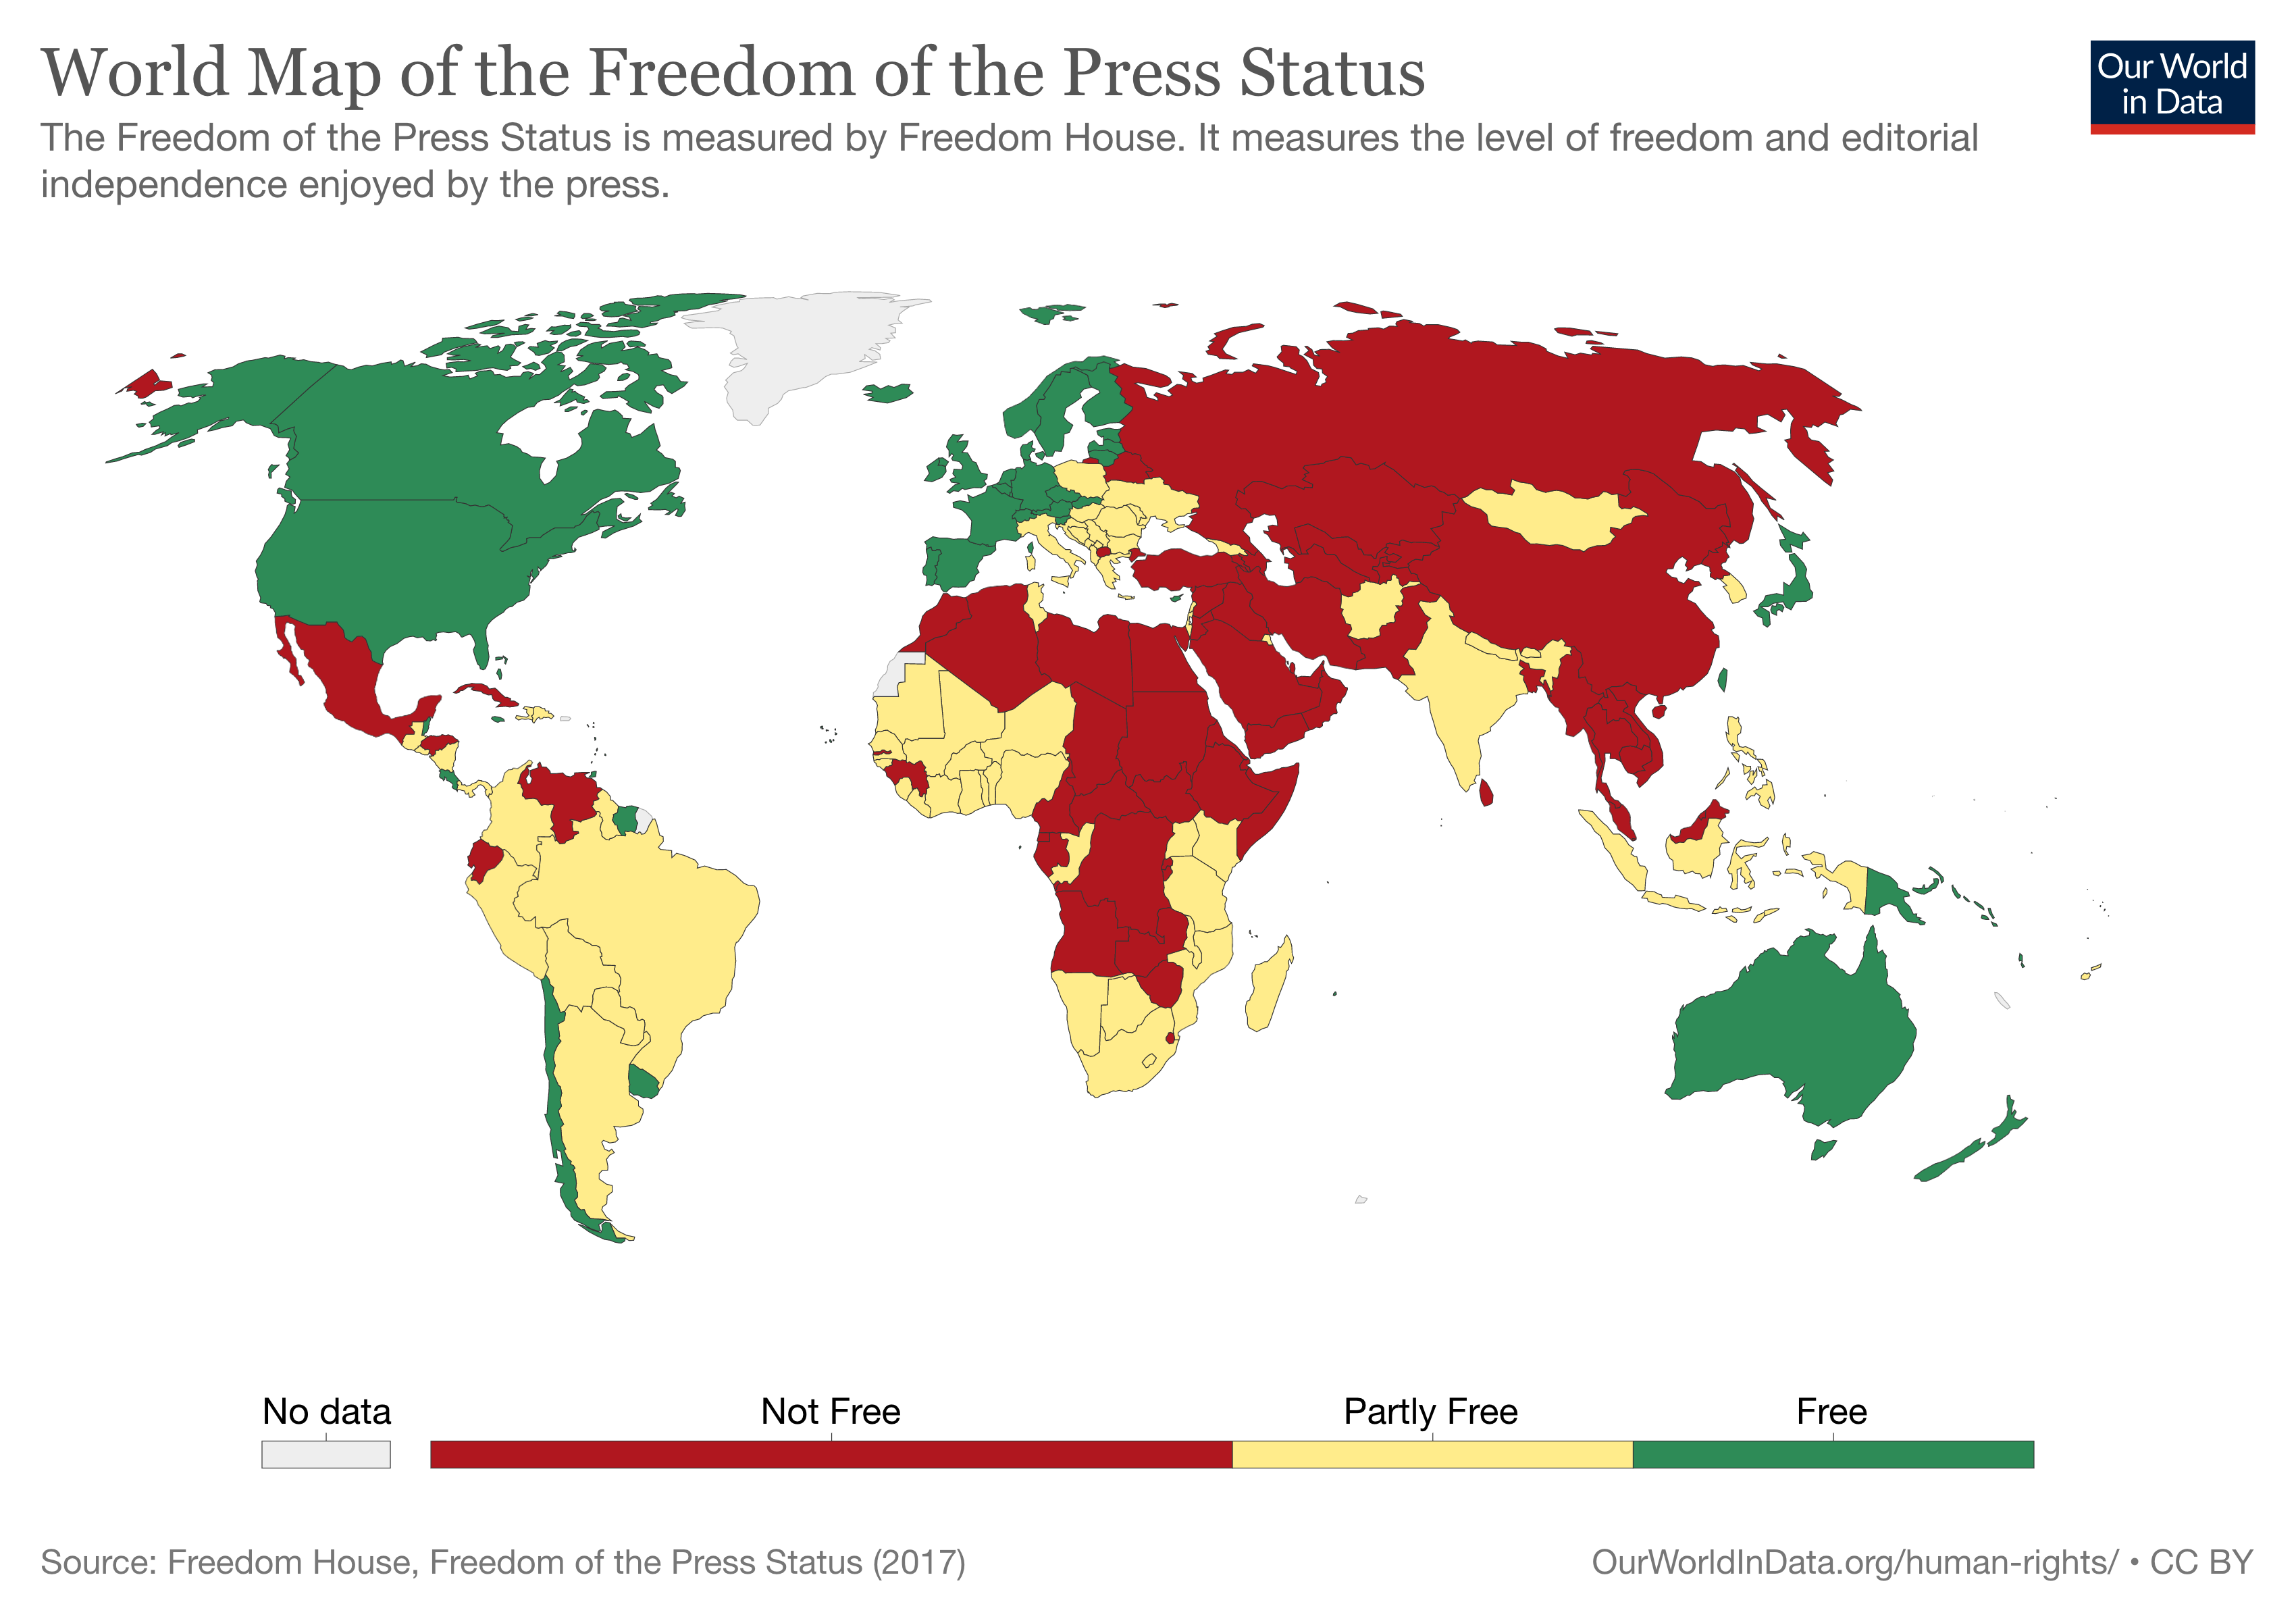

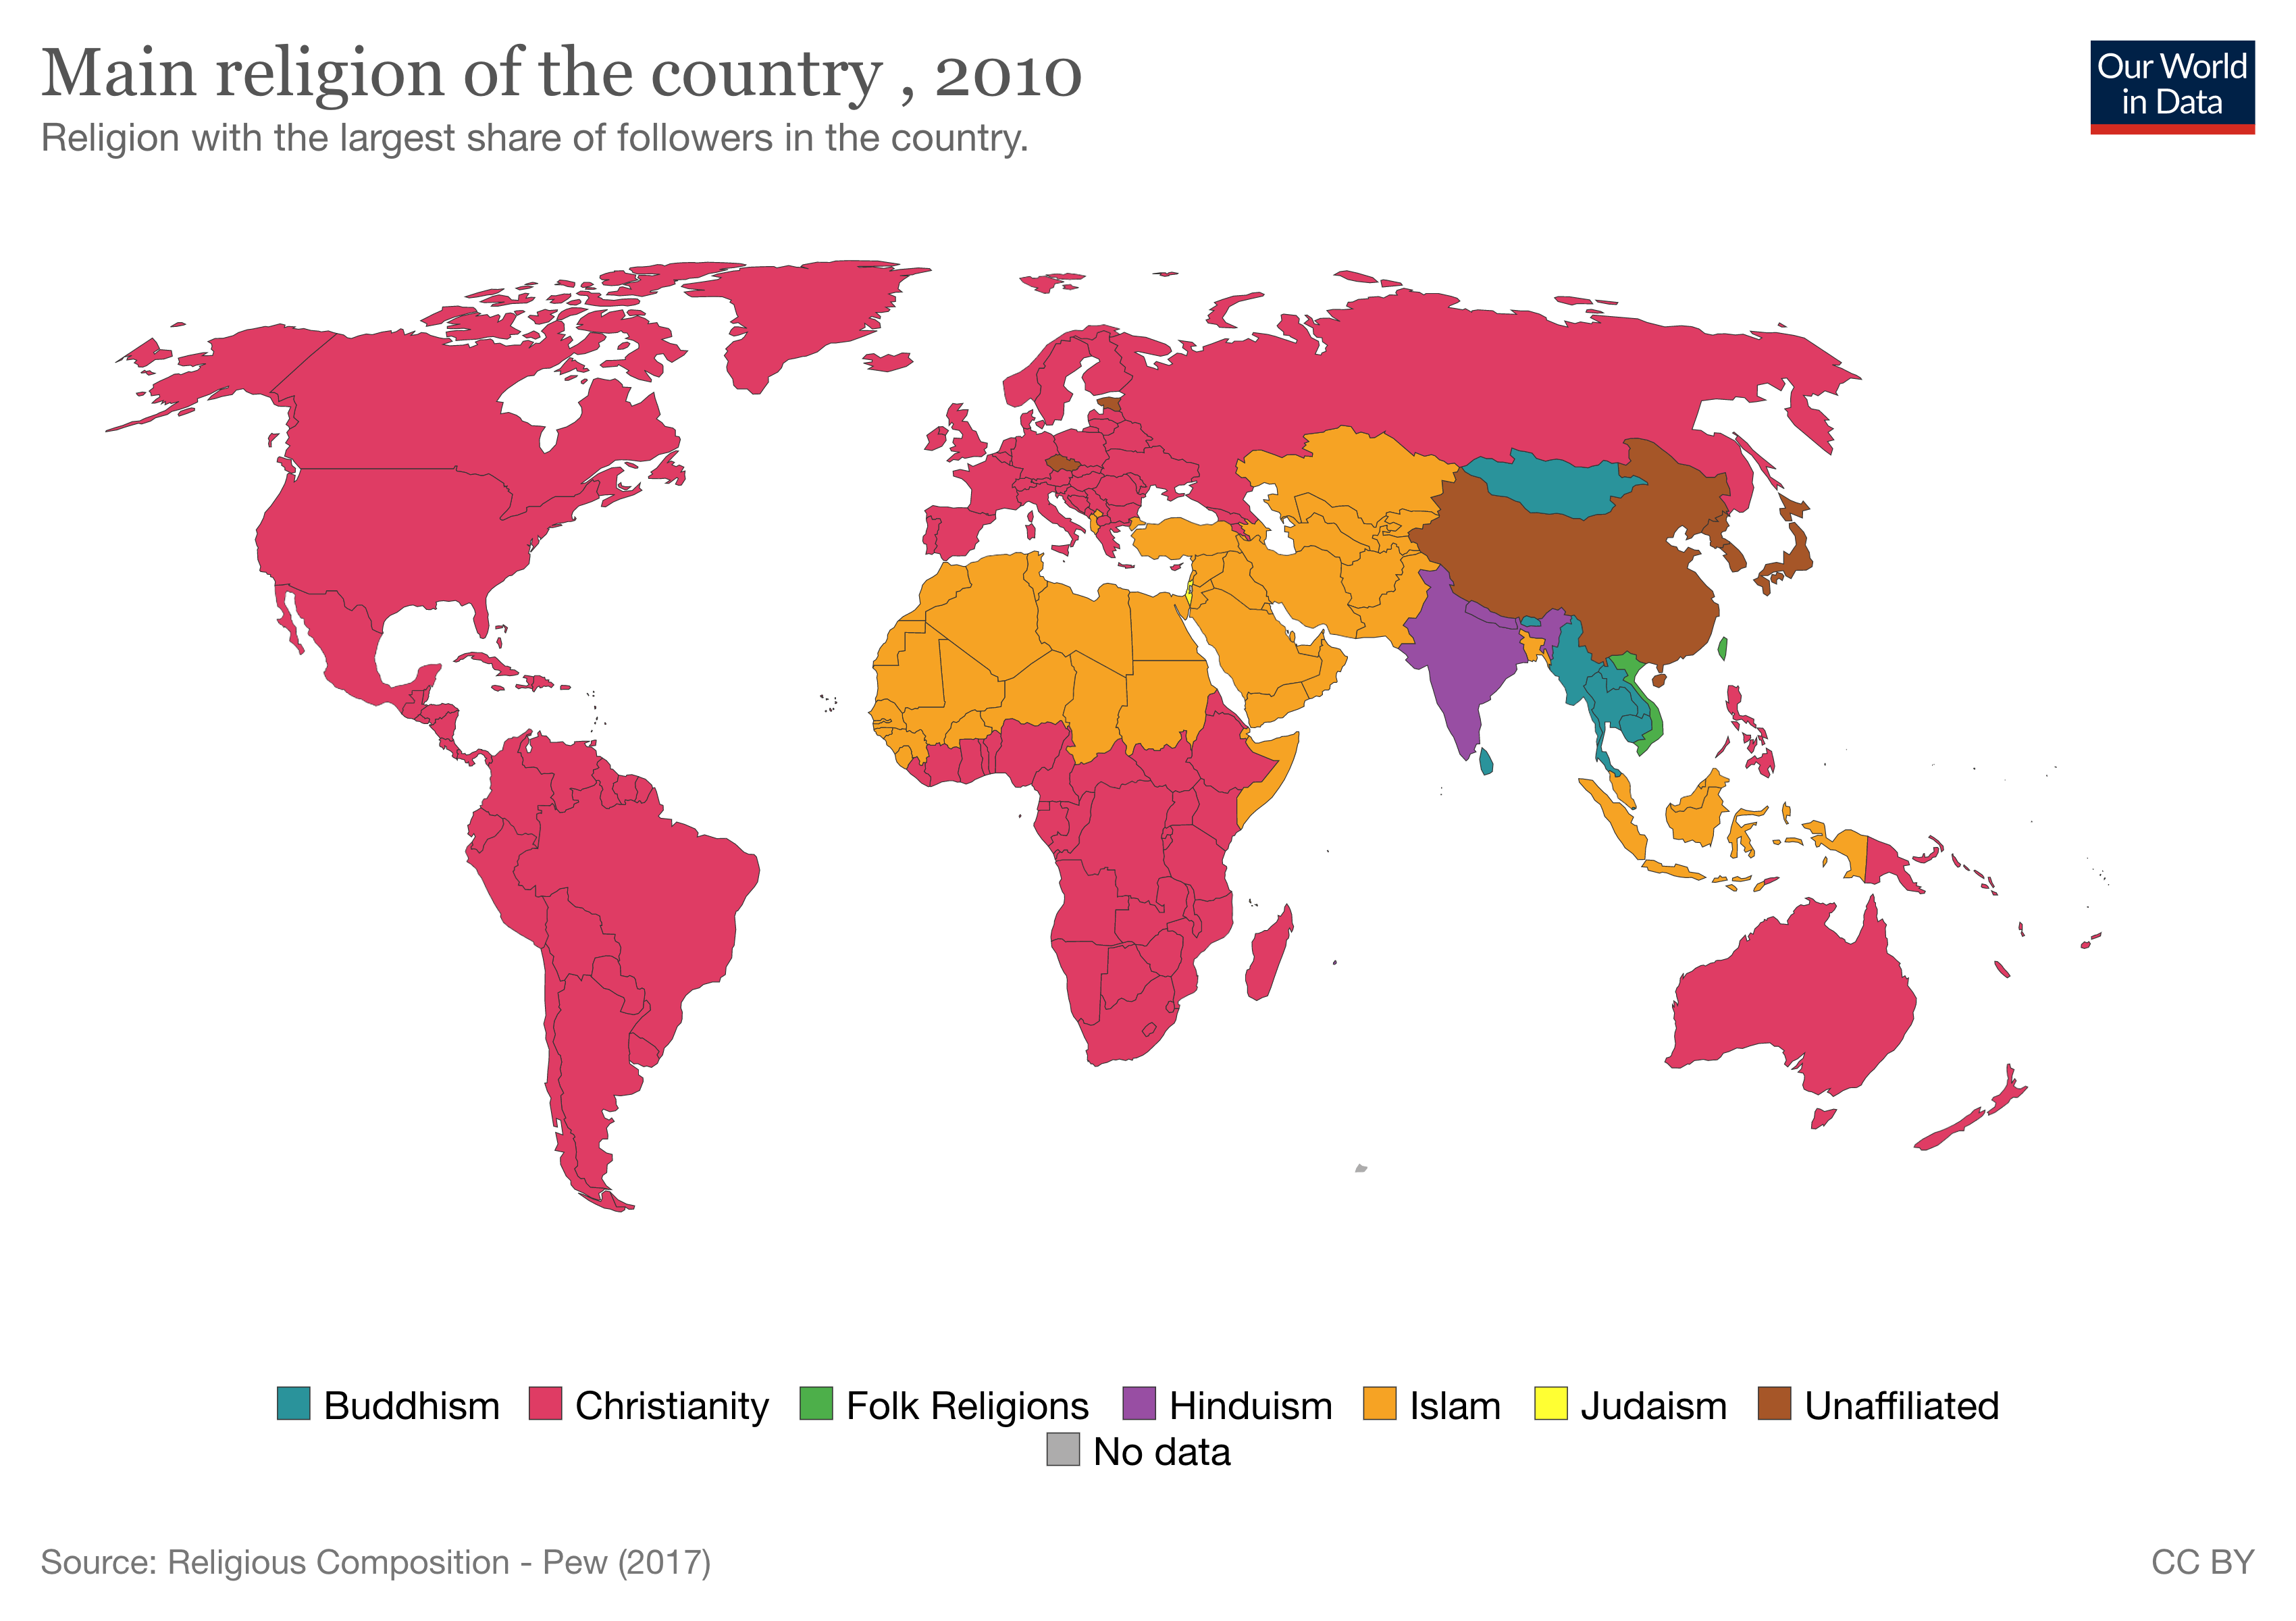

#### **Histograms and Pie Charts**

In [111]:
def histogram(df, x):
  fig = px.histogram(df, x=x, histnorm='probability density', width=600, height=400)
  fig.update_layout(bargap=0.01)
  fig.show()
  return
  
# histograms for numerical and bars for categorical and ordinal dataset
display(Markdown("#**<center>Histograms for the numerical features**"))

for eachFeature in vaccinationData[['people_vaccinated_per_hundred', 'Tertiary education 15+', 'People who agree vaccines are safe', 'People who trust doctors and nurses in their country', 'TrustPolitician']]:
  histogram(vaccinationData, eachFeature)

#**<center>Histograms for the numerical features**

In [112]:
def pieChartCat(df, x):
  labels = df[x].value_counts().index.tolist()
  values = df[x].value_counts().tolist()
  fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent')])
  fig.show()
  return
  
def pieChartOrd(df, x, flag):
  if flag:
    categories = {0 : 'Closed autocracy',
                  1 : 'Electoral autocracy',
                  2 : 'Electoral democracy', 
                  3 : 'Liberal democracy'}
  else:
    categories = {1500 : 'Not Free',
                  2500 : 'Partly Free',
                  3500 : 'Free'}


  plabels = df[x].value_counts().index.tolist()
  pvalues = df[x].value_counts().tolist()
  items = [(plabels[i] , pvalues[i]) for i in range(len(plabels))]
  items.sort()
  labels = [categories[items[i][0]] for i in range(len(items))]
  values = [item[1] for item in items]

  fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent')])
  fig.show()
  return

# pieChart for numerical and bars for categorical and ordinal dataset
display(Markdown("#**<center>Pie charts for categorical features**"))
for eachFeature in vaccinationData[["Main religion "]]:
  pieChartCat(vaccinationData, eachFeature)

display(Markdown("#**<center>Pie charts for ordinal features**"))
pieChartOrd(vaccinationData, 'Political Regime', True)
pieChartOrd(vaccinationData, 'Freedom of the Press Status', False)


#**<center>Pie charts for categorical features**

#**<center>Pie charts for ordinal features**

## **Correlation**

#### **Scatter Plot**
It is worth starting with scatter plots of each independent variable against the dependent variable in order to assess whether there is an underlying linear relationship and whether the variance is constant.

In [113]:
# x and y given as DataFrame columns
def scatterPlot(df, x):
  fig = px.scatter(df, x=x, y='people_vaccinated_per_hundred', 
                   labels={
                     'people_vaccinated_per_hundred': "People vaccinated Per Hundred",
                 },  
                  trendline="lowess", width=600, height=400)
  fig.show()

vaccinationData = vaccinationData[vaccinationData.people_vaccinated_per_hundred <=100] 

for eachFeature in vaccinationData[['Tertiary education 15+', 'People who agree vaccines are safe', 'People who trust doctors and nurses in their country', 'TrustPolitician']]:
  scatterPlot(vaccinationData, eachFeature) 


> We have three increasing relations.

> 'People who agree vaccines are safe' is increasing than decreasing. Meaning there are other more powerful factors in those countries that are causing this behaviour. 

#### **Correlation Coefficient**


**Pearson’s Correlation:**

The Pearson correlation coefficient (named for Karl Pearson) can be used to summarize the strength of the linear relationship between two data samples.

$ r=\ \frac{\sum ( x_{i} -\overline{x})( y_{i} -\overline{y})}{\sqrt{\sum ( x_{i} -\overline{x})^{2}( y_{i} -\overline{y})^{2}}} $


The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution.

The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.

________________________________________________________________________

**Spearman’s Correlation:**

Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables.

Further, the two variables being considered may have a non-Gaussian distribution.

$\rho =1-\frac{6\sum d_{i}^{2}}{n\left( n^{2} -1\right)}$

In this case, the Spearman’s correlation coefficient (named for Charles Spearman) can be used to summarize the strength between the two data samples. This test of relationship can also be used if there is a linear relationship between the variables, but will have slightly less power (e.g. may result in lower coefficient scores).

As with the Pearson correlation coefficient, the scores are between -1 and 1 for perfectly negatively correlated variables and perfectly positively correlated respectively.

In [114]:
covarianceSpearman = vaccinationData.corr(method='spearman')
covarianceSpearman.sort_values('people_vaccinated_per_hundred', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

covariancePearson = vaccinationData.corr(method='pearson')
covariancePearson.sort_values('people_vaccinated_per_hundred', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

In [115]:
display(Markdown("#**Spearman's Rank Correlation Coefficient**"))
covarianceSpearman

#**Spearman's Rank Correlation Coefficient**

,people_vaccinated_per_hundred,Freedom of the Press Status,Political Regime,Tertiary education 15+,People who agree vaccines are safe,People who trust doctors and nurses in their country,TrustPolitician
people_vaccinated_per_hundred,1.000000,0.439429,0.436748,0.583647,-0.393048,0.518008,0.326599
Tertiary education 15+,0.583647,0.447688,0.436013,1.000000,-0.420964,0.492234,0.249526
People who trust doctors and nurses in their country,0.518008,0.341350,0.391439,0.492234,-0.017873,1.000000,0.455230
Freedom of the Press Status,0.439429,1.000000,0.809504,0.447688,-0.423160,0.341350,0.144018
Political Regime,0.436748,0.809504,1.000000,0.436013,-0.387965,0.391439,0.112718
TrustPolitician,0.326599,0.144018,0.112718,0.249526,-0.221623,0.455230,1.000000
People who agree vaccines are safe,-0.393048,-0.423160,-0.387965,-0.420964,1.000000,-0.017873,-0.221623


In [116]:
display(Markdown("#**Pearson Correlation Coefficient**"))
covariancePearson

#**Pearson Correlation Coefficient**

,people_vaccinated_per_hundred,Freedom of the Press Status,Political Regime,Tertiary education 15+,People who agree vaccines are safe,People who trust doctors and nurses in their country,TrustPolitician
people_vaccinated_per_hundred,1.000000,0.435931,0.397590,0.515490,-0.265072,0.498374,0.406391
Tertiary education 15+,0.515490,0.455832,0.420329,1.000000,-0.422647,0.484432,0.344316
People who trust doctors and nurses in their country,0.498374,0.315343,0.337772,0.484432,-0.007478,1.000000,0.433332
Freedom of the Press Status,0.435931,1.000000,0.797329,0.455832,-0.354151,0.315343,0.155168
TrustPolitician,0.406391,0.155168,0.066875,0.344316,-0.142537,0.433332,1.000000
Political Regime,0.397590,0.797329,1.000000,0.420329,-0.309769,0.337772,0.066875
People who agree vaccines are safe,-0.265072,-0.354151,-0.309769,-0.422647,1.000000,-0.007478,-0.142537


#### **Heat Map**

In [117]:
def correlationCoeff(df, method):
  ''' Returns the pairwise correlation coefficients using pearson or spearman method '''
  corrdata = vaccinationData.drop(columns=['country', 'Code'])
  corr = corrdata.corr(method = method).abs()
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  corr1 = corr.mask(mask)

  fig = ff.create_annotated_heatmap(
      z=corr1.to_numpy().round(2),
      x=list(corr1.index.values),
      y=list(corr1.columns.values),       
      xgap=3, ygap=3,
      zmin=0, zmax=1,
      colorscale='YlOrRd',
      colorbar_thickness=30,
      colorbar_ticklen=3,
  )
  fig.update_layout(
      title_text='<span style="font-size:32px; font-family:Times New Roman">Features Correlation Matrix Using {} Method</span>'.format(method.capitalize()), 
      font_family="Serif",
      titlefont={'size': 24},
      width=800, height=700,
      xaxis={'side': 'bottom'},
      xaxis_showgrid=False,
      yaxis_showgrid=False,
      yaxis_autorange='reversed', 
      paper_bgcolor="rgba(0, 0, 0, 0)",
      plot_bgcolor="rgba(254, 227, 223, 0.5)",
      margin=dict(l=70, r=70, t=70, b=70, pad=1),
  )

  fig.show()
  return 

In [118]:
correlationCoeff(vaccinationData, 'pearson')

In [119]:
correlationCoeff(vaccinationData, 'spearman')

**Degree of correlation:**

**Perfect:** If the value is near $±1$, then it said to be a perfect correlation, as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).

**High degree:** If the coefficient value lies between $±0.50$ and $±1$, then it is said to be a strong correlation.

**Moderate degree:** If the value lies between $±0.30$ and $±0.49$, then it is said to be a medium correlation.

**Low degree:** When the value lies below $+0.29$, then it is said to be a small correlation.

**No correlation:** When the value is zero.

> We can see that **'Freedom of the Press Status'** and **'Political Regime'** are perfectly correlated.



> **'People vaccinated per hundred'** has the following correlations:
>
>**High degree:** Tertiary education 15+, People who trust doctors and nurses in their country.
>
>**Moderate degree:** Freedom of the Press Status, Trust in Politicians, Political Regime.
>
>**Low degree:** People who agree vaccines are safe.

## **Feature Importance**

A small error in a machine learning algorithm indicates that the algorithm can predict the response variable better and has a good understanding of the relation between the response and predictor variables. 

We try three decision-tree-based machine learning algorithms namely **"Decision Tree Regressor"**, **"Random Forest Regressor"**, and **"XGB Regressor"**. Then calculate the error using **RMSE**:

$MSE=\sqrt{\frac{\sum\limits _{i=1}^{n}( y_{i} -\overline{y})^{2}}{n}}$

#### **Data preproccesing**

In [120]:
def preprocess(df, drop_cor= True):
  '''Performs the necessary preprocessing of data'''

  # Encoding categorical values
  def encoding(df,x):
    x_ = pd.get_dummies(df[x]) # using dummy variables
    df = pd.concat([x_, df], axis=1)
    df.drop(columns=[x], inplace=True)  
    df.columns
    return df

  #df.columns
  print("size raw",df.shape)
  df = df.dropna(axis=0)
  print("size_dropna",df.shape)
  df.drop(columns=[ 'Code', 'country', 'date'], inplace=True) 
  dic_polit = {0 : 'Closed autocracy',
                1 : 'Electoral autocracy',
                  2 : 'Electoral democracy', 
                  3 : 'Liberal democracy'}
  
  dic_free = {1500 : 'Not Free',2500 : 'Partly Free', 3500 : 'Free'}
  for k, v in dic_free.items():
    df.loc[(df['Freedom of the Press Status'] == k),'Freedom of the Press Status']= v
  for k, v in dic_polit.items():
    df.loc[(df['Political Regime'] == k),'Political Regime']= v

  if drop_cor:
    df.drop(columns=['Freedom of the Press Status'], inplace=True) 
    for feature in ['Main religion ', 'Political Regime']:
      df = encoding(df,feature)
  else:
    for feature in ['Main religion ','Freedom of the Press Status', 'Political Regime']:
      df = encoding(df,feature)
    
  y = df.loc[:, 'people_vaccinated_per_hundred']
  X = df.drop(columns=['people_vaccinated_per_hundred'])
  cols = X.columns.to_list()
  print("X columsDFFDFDFDF: ", X.columns)
  X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
  scaler = MinMaxScaler() 
  scaler.fit(X_train) # scalling the features (x_train)
  X_train = scaler.transform(X_train)
  x_test = scaler.transform(x_test)
  return X_train, x_test , y_train, y_test, cols

#### **Implementing Feature Importance**

Feature importance scores can provide insight into the dataset. The relative scores can highlight which features may be most relevant to the target, and the converse, which features are the least relevant. This may be interpreted by a domain expert and could be used as the basis for gathering more or different data.

In [121]:
def get_model_acc(model, test_x, test_y):
  '''Returns the RMSE of the model'''
  y_pred = model.predict(test_x)
  return mean_squared_error(test_y, y_pred)

def feat_importance(model, f_array):

  feat_import =  model.feature_importances_

  z = list(zip(f_array ,feat_import))
  res = sorted(z, key = lambda x: x[1],reverse=True)
  return res
  
#plot(x= f, y= feat_import)
def barplot(result):
  x,y = [],[]
  for el in result:
    x.append(el[0])
    y.append(el[1])
  fig = px.bar(x=x, y=y)
  fig.show()

In [122]:
def main(drop_free=False):
  df =  vaccinationData.copy()
  X_train, x_test , y_train, y_test, cols = preprocess(df,drop_free) #drop free
  tree_reg = DecisionTreeRegressor(random_state=42)
  forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
  xgboost = xgb.XGBRegressor(objective='reg:squarederror')
  rmse = []
  dic = dic = {"DecisionTreeRegressor":tree_reg ,"RandomForestRegressor":forest_reg , "XGBRegressor": xgboost}
  for k,v in dic.items():
    model = v
    model.fit(X_train, y_train)

    display(Markdown("**Root mean square error using: {}**".format(k)))
    print(math.sqrt(get_model_acc(model, x_test, y_test)))
    result = feat_importance(model,cols)
    print(result)
    barplot(result)

main()

size raw (203, 11)
size_dropna (100, 11)
X columsDFFDFDFDF:  Index(['Closed autocracy', 'Electoral autocracy', 'Electoral democracy',
       'Liberal democracy', 'Free', 'Not Free', 'Partly Free', 'Buddhism',
       'Christianity', 'Folk Religions', 'Hinduism', 'Islam',
       'Unaffiliated Religions', 'Tertiary education 15+',
       'People who agree vaccines are safe',
       'People who trust doctors and nurses in their country',
       'TrustPolitician'],
      dtype='object')


**Root mean square error using: DecisionTreeRegressor**

14.972201240966541
[('Free', 0.5270481855451635), ('People who agree vaccines are safe', 0.1976480891644441), ('TrustPolitician', 0.10829586026122223), ('Tertiary education 15+', 0.07007481448123604), ('People who trust doctors and nurses in their country', 0.04638937102328535), ('Electoral autocracy', 0.03895985872495398), ('Buddhism', 0.011009717981176378), ('Christianity', 0.0003790487082157679), ('Electoral democracy', 9.912795801932876e-05), ('Unaffiliated Religions', 9.194486763989084e-05), ('Liberal democracy', 3.822242982917437e-06), ('Not Free', 1.5904166046992997e-07), ('Closed autocracy', 0.0), ('Partly Free', 0.0), ('Folk Religions', 0.0), ('Hinduism', 0.0), ('Islam', 0.0)]


**Root mean square error using: RandomForestRegressor**

12.345185633314712
[('Free', 0.5121590333870973), ('Tertiary education 15+', 0.16060055093127434), ('People who agree vaccines are safe', 0.10134520302561714), ('TrustPolitician', 0.096021814850116), ('People who trust doctors and nurses in their country', 0.06261815054912884), ('Electoral autocracy', 0.01630784826208663), ('Unaffiliated Religions', 0.013098256085979944), ('Buddhism', 0.01048663332153927), ('Closed autocracy', 0.010142213347160412), ('Electoral democracy', 0.005609023603135282), ('Christianity', 0.004666221081835519), ('Liberal democracy', 0.0019698573858228903), ('Not Free', 0.0016607164287830384), ('Partly Free', 0.0011552813305169471), ('Hinduism', 0.0010241397204762488), ('Islam', 0.0007736052266634956), ('Folk Religions', 0.00036145146276665913)]


**Root mean square error using: XGBRegressor**

11.430753728523545
[('Free', 0.7942959), ('Electoral autocracy', 0.03746646), ('Christianity', 0.027822167), ('Tertiary education 15+', 0.027176512), ('People who agree vaccines are safe', 0.02220684), ('People who trust doctors and nurses in their country', 0.016854938), ('Partly Free', 0.015529215), ('TrustPolitician', 0.012631503), ('Closed autocracy', 0.011858828), ('Unaffiliated Religions', 0.010819758), ('Buddhism', 0.008969507), ('Electoral democracy', 0.0071843895), ('Folk Religions', 0.007144768), ('Not Free', 3.9302424e-05), ('Liberal democracy', 0.0), ('Hinduism', 0.0), ('Islam', 0.0)]


> XGBRegressor has the minimum error of $11.430753728523545$.

> Here, the top two features that have the most predictive power are **Free press status** and **Higher Education**. And other variables' power are very close to zero. 

> As we previously saw in the heat map, our variables are strongly intercorrelated, therefore the model gives a very large coefficient to one variable ( here, free press status) and sets the coefficient of variables that are correlated with it to very small numbers. Thus to see the relations better, we run the test again with the 'free press status' variable dropped. 
> 

In [123]:
main(True)

size raw (203, 11)
size_dropna (100, 11)
X columsDFFDFDFDF:  Index(['Closed autocracy', 'Electoral autocracy', 'Electoral democracy',
       'Liberal democracy', 'Buddhism', 'Christianity', 'Folk Religions',
       'Hinduism', 'Islam', 'Unaffiliated Religions', 'Tertiary education 15+',
       'People who agree vaccines are safe',
       'People who trust doctors and nurses in their country',
       'TrustPolitician'],
      dtype='object')


**Root mean square error using: DecisionTreeRegressor**

28.45201574581316
[('Tertiary education 15+', 0.3710823196717259), ('TrustPolitician', 0.20946840171781828), ('People who agree vaccines are safe', 0.12870195629071518), ('People who trust doctors and nurses in their country', 0.09776020494238265), ('Christianity', 0.06801019243022106), ('Electoral autocracy', 0.04592658511201185), ('Unaffiliated Religions', 0.03192696293284873), ('Electoral democracy', 0.030871469541653263), ('Closed autocracy', 0.015562832714052515), ('Liberal democracy', 0.0006890274583856815), ('Folk Religions', 4.7188184974537126e-08), ('Buddhism', 0.0), ('Hinduism', 0.0), ('Islam', 0.0)]


**Root mean square error using: RandomForestRegressor**

15.057898971503294
[('Tertiary education 15+', 0.2877179284590511), ('People who trust doctors and nurses in their country', 0.21902164187116108), ('People who agree vaccines are safe', 0.16060540498181466), ('TrustPolitician', 0.130816791114698), ('Liberal democracy', 0.09593874509504818), ('Electoral autocracy', 0.044315865037933735), ('Christianity', 0.016974759471692233), ('Unaffiliated Religions', 0.013186504387235128), ('Buddhism', 0.009188703835405113), ('Electoral democracy', 0.008921612269780967), ('Closed autocracy', 0.0065070460561239074), ('Islam', 0.005239295409872291), ('Hinduism', 0.0011307870070243222), ('Folk Religions', 0.0004349150031593803)]


**Root mean square error using: XGBRegressor**

13.581206883116758
[('Liberal democracy', 0.50269926), ('Electoral autocracy', 0.15745494), ('Tertiary education 15+', 0.0865873), ('People who agree vaccines are safe', 0.050084107), ('People who trust doctors and nurses in their country', 0.045338582), ('Christianity', 0.034756955), ('Unaffiliated Religions', 0.030421486), ('TrustPolitician', 0.028839823), ('Buddhism', 0.023440836), ('Electoral democracy', 0.017065138), ('Closed autocracy', 0.014588651), ('Hinduism', 0.0068497355), ('Islam', 0.0018731914), ('Folk Religions', 0.0)]


> Again, XGBRegressor has the minimum error of $13.581206883116758$.

> Here, the top two features that have the most predictive power are **Electoral democracy** and **Electoral autocracy**. These scores could be either poisitive or negative, looking back to correlaton figures, we see that the they have a **positive** effect. After that **Higher education** has the most power.

# <center>**Results**

Using nationally representative data from the 204 countries around the world, I found a significant **positive correlation** between **people vaccinated per hundred** and **freedom of the press status** for a given country.

**Political features** have a **stronger** correlation with people vaccinated per hundred than **social features**. 

People more likely to be vaccinated from countries that: 
1.  The press has the freedom
2.  Has Liberal democracy or Electoral autocracy.
3.  More people have tertiary education.
4.  More people agree with vaccine safety.

For future short-term or long-term plans to get more countries fully vaccinated, we have to first **democratize** the countries and ensure freedom of the press. For countries that already are democratized, we have to encourage people to pursue **higher education** after high school and expand people's medical knowledge to increase their **trust in doctors and nurses** and **vaccine safety**. 

# <center>**Resources**

1. Hannah Ritchie, Esteban Ortiz-Ospina, Diana Beltekian, Edouard Mathieu, Joe Hasell, Bobbie Macdonald, Charlie Giattino, Cameron Appel, Lucas Rodés-Guirao and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]

2. Freedom House(1979 – 2017) - “Freedom of the Press Status”.Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/world-map-of-the-freedom-of-the-press-status’ [Online Resource]

3. Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Michael Bernhard, M. Steven Fish, Adam Glynn, Allen Hicken, Anna L¨uhrmann, Kyle L. Marquardt, Kelly McMann, Pamela Paxton, Daniel Pemstein, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Steven Wilson, Agnes Cornell, Lisa Gastaldi, Haakon Gjerløw, Nina Ilchenko, Joshua Krusell, Laura Maxwell, Valeriya Mechkova, Juraj Medzihorsky, Josefine Pernes, Johannes von R¨omer, Natalia Stepanova, Aksel Sundstr¨om, Eitan Tzelgov, YitingWang, Tore Wig, and Daniel Ziblatt. 2019. ”V-Dem [Country-Year/Country-Date] Dataset v9” Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/vdemcy19..Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/political-regimes’ [Online Resource]

4. Pew-Templeton Global Religious Futures Project, Pew Research Center (2017) -”​​Main religion of the country”. Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/main-religion-of-the-country-in’’ [Online Resource]

5. Lutz, Wolfgang, William P. Butz, and Samir (2014) World population and human capital in the twenty-first century. Oxford: Oxford University Press.-”Projections of the share of the population aged 15+ educated to degree level by country, 1970 to 2020”. Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/projections-of-the-share-of-the-population-aged-15-educated-to-degree-level-by-country?time=earliest..2020’ [Online Resource]

6. The Wellcome Global Monitor (2018)-”SHARE OF PEOPLE WHO TRUST DOCTORS AND NURSES IN THEIR COUNTRY”. Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/share-who-trust-doctors-and-nurses’ [Online Resource]

7.  Global Competitiveness Index (2017-2018)-”SHARE OF PEOPLE WHO TRUST POLITICIANS  IN THEIR COUNTRY’. Published online at reports.weforum.org. Retrieved from: ‘http://reports.weforum.org/global-competitiveness-index-2017-2018/downloads/’ [Online Resource]

8. Wellcome Trust  Global Monitor (2019)-”SHARE OF PEOPLE WHO AGREE VACCINES ARE SAFE (WELLCOME TRUST, 2019)” Published online at OurWorldInData.org. Retrieved from: ‘https://ourworldindata.org/grapher/share-agree-vaccines-are-safe-wellcome’ [Online Resource]

9. Data structures for statistical computing in python, McKinney, Proceedings of the 9th Python in Science Conference, Volume 445, 2010.

10. Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 0.1038/s41586-020-2649-2. 

11. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

12. Sturgis, P., Brunton-Smith, I. & Jackson, J. Trust in science, social consensus and vaccine confidence. Nat Hum Behav (2021). https://doi.org/10.1038/s41562-021-01115-7

13. Murphy, J., Vallières, F., Bentall, R.P. et al. Psychological characteristics associated with COVID-19 vaccine hesitancy and resistance in Ireland and the United Kingdom. Nat Commun 12, 29 (2021). https://doi.org/10.1038/s41467-020-20226-9

14. https://machinelearningmastery.com/calculate-feature-importance-with-python/

15. https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/

